In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split

In [2]:
# Directories containing the images
normal_dir = '/content/drive/MyDrive/Final Project/Datasets/Prem/Train/normal'
pneumonia_dir = '/content/drive/MyDrive/Final Project/Datasets/Prem/Train/pneumonia'

In [3]:
# Define image dimensions and batch size
img_height, img_width = 128, 128
batch_size = 32

In [4]:
# 1. Data Loading and Preprocessing
def load_data(normal_dir, pneumonia_dir, img_height=128, img_width=128):
    normal_images = []
    pneumonia_images = []

    # Load normal images
    for filename in os.listdir(normal_dir):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(normal_dir, filename), target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        normal_images.append(img_array)

    # Load pneumonia images
    for filename in os.listdir(pneumonia_dir):
        img = tf.keras.preprocessing.image.load_img(
            os.path.join(pneumonia_dir, filename), target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        pneumonia_images.append(img_array)

    # Convert to numpy arrays and assign labels
    X_normal = np.array(normal_images)
    X_pneumonia = np.array(pneumonia_images)

    y_normal = np.zeros(X_normal.shape[0])
    y_pneumonia = np.ones(X_pneumonia.shape[0])

    X = np.concatenate([X_normal, X_pneumonia], axis=0)
    y = np.concatenate([y_normal, y_pneumonia], axis=0)

    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_data(normal_dir, pneumonia_dir)

In [5]:
# 2. Define GAN for Data Augmentation
def build_generator():
    model = models.Sequential([
        layers.Dense(128 * 32 * 32, activation="relu", input_dim=100),
        layers.Reshape((32, 32, 128)),
        layers.Conv2DTranspose(128, (4,4), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2DTranspose(64, (4,4), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(3, (7,7), activation="tanh", padding="same")
    ])
    return model

def build_discriminator():
    model = models.Sequential([
        layers.Conv2D(64, (4,4), strides=(2,2), padding="same", input_shape=(img_height, img_width, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Conv2D(128, (4,4), strides=(2,2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.4),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid")
    ])
    return model

In [6]:
# Build and compile GAN
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(0.0002, 0.5), metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [7]:
# GAN model
z = layers.Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
gan = models.Model(z, valid)
gan.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(0.0002, 0.5))

In [8]:
# Training function for GAN
def train_gan(generator, discriminator, gan, epochs=50, batch_size=32):
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_images = generator.predict(noise)

        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        d_loss_real = discriminator.train_on_batch(real_images, real_labels)
        d_loss_fake = discriminator.train_on_batch(gen_images, fake_labels)

        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, 100))
        valid_y = np.ones((batch_size, 1))
        g_loss = gan.train_on_batch(noise, valid_y)

        # Print the progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {0.5 * np.add(d_loss_real, d_loss_fake)}] [G loss: {g_loss}]")

In [9]:
# Train the GAN model
train_gan(generator, discriminator, gan)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: [1.7374457 0.7578125]] [G loss: [array(1.3893094, dtype=float32), array(1.3893094, dtype=float32), array(0.703125, dtype=float32)]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


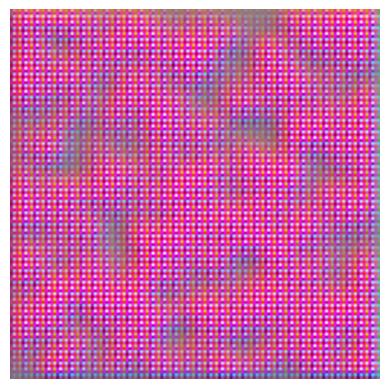

In [10]:
import matplotlib.pyplot as plt

def display_generated_image(generator, latent_dim=100):
    # Generate a random noise vector
    noise = np.random.normal(0, 1, (1, latent_dim))

    # Use the generator to create an image
    generated_image = generator.predict(noise)

    # Rescale the image from [-1, 1] to [0, 1]
    generated_image = 0.5 * generated_image + 0.5

    # Display the generated image
    plt.imshow(generated_image[0])
    plt.axis('off')
    plt.show()

# Display a GAN-generated image
display_generated_image(generator)

In [11]:
# Data augmentation using GAN-generated images
def generate_synthetic_images(generator, num_samples=500):
    noise = np.random.normal(0, 1, (num_samples, 100))
    return generator.predict(noise)

In [12]:
# Add synthetic images to training data
synthetic_images = generate_synthetic_images(generator)
synthetic_labels = np.ones(synthetic_images.shape[0])

X_train_augmented = np.concatenate([X_train, synthetic_images], axis=0)
y_train_augmented = np.concatenate([y_train, synthetic_labels], axis=0)

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step


In [13]:
# 3. CNN Model for Classification
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [14]:
# Train the CNN on augmented dataset
cnn_model.fit(X_train_augmented, y_train_augmented, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 11s 124ms/step - accuracy: 0.6684 - loss: 53.1952 - val_accuracy: 1.0000 - val_loss: 1.1590e-06
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9245 - loss: 0.1866 - val_accuracy: 1.0000 - val_loss: 5.3874e-06
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9529 - loss: 0.1357 - val_accuracy: 1.0000 - val_loss: 7.1514e-05
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9685 - loss: 0.0811 - val_accuracy: 1.0000 - val_loss: 3.1190e-09
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9775 - loss: 0.0581 - val_accuracy: 1.0000 - val_loss: 3.7994e-09
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9926 - loss: 0.0384 - val_accuracy: 1.0000 - val_loss: 4.4634e-08
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9932 - loss: 0.0223 - val_accuracy: 1.0000 - val_loss: 4.0814e-14
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9895 - loss: 0.

In [15]:
# Evaluate the CNN model
loss, accuracy = cnn_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.9309 - loss: 0.1424
Test Accuracy: 93.43%


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


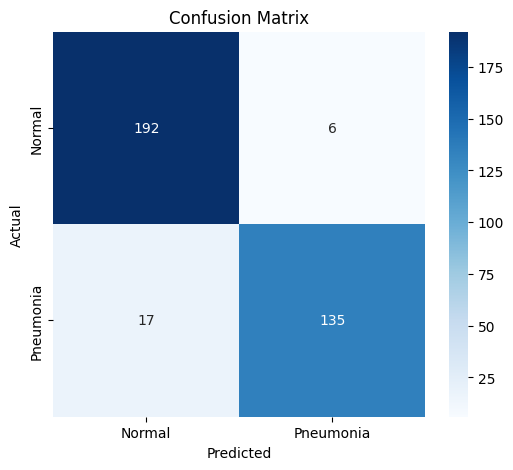

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the labels for the test set
y_pred = cnn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")  # Convert probabilities to binary labels

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)

# Print the results
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Precision: 0.96
Recall: 0.89
F1-score: 0.92


In [18]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=["Normal", "Pneumonia"])

# Print the classification report
print(report)


              precision    recall  f1-score   support

      Normal       0.92      0.97      0.94       198
   Pneumonia       0.96      0.89      0.92       152

    accuracy                           0.93       350
   macro avg       0.94      0.93      0.93       350
weighted avg       0.94      0.93      0.93       350



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


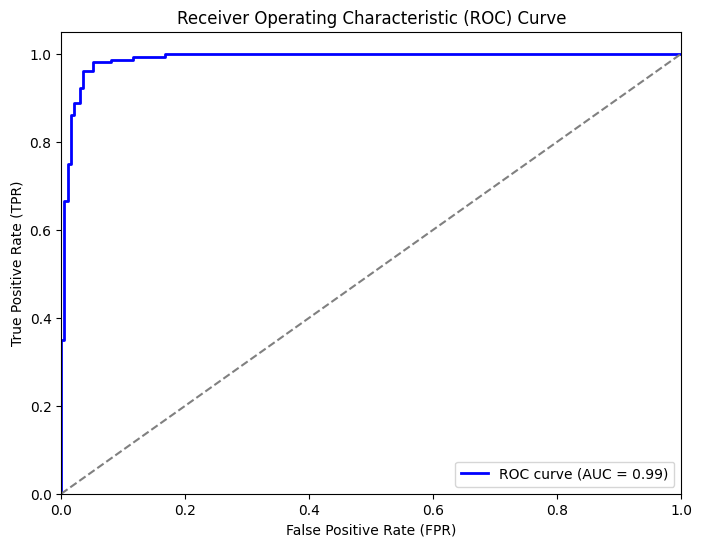

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate predicted probabilities for the test set
y_pred_prob = cnn_model.predict(X_test)  # Model predicts probabilities

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [19]:
# Save the trained model to a file
cnn_model.save('pneumonia_classification_model.h5')
print("Model saved successfully.")

Model saved successfully.


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image

# Function to load and preprocess a single image
def load_and_preprocess_image(image_path, img_height=128, img_width=128):
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)  # Convert the image to an array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image to [0, 1]
    return img_array

# Function to make predictions on a single image
def predict_image(model, image_path):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)  # Predict the class probabilities
    class_prediction = (prediction > 0.5).astype("int32")  # Convert probabilities to binary labels
    return class_prediction[0][0], prediction[0][0]  # Return predicted class (0 or 1) and probability

# Example usage
image_path = '/content/drive/MyDrive/Final Project/Datasets/Prem/Validation/Pnuemonia/person1949_bacteria_4880.jpeg'  # Specify the path to the image you want to predict

# Make a prediction on the image
predicted_class, predicted_probability = predict_image(cnn_model, image_path)

# Output the result
if predicted_class == 0:
    print(f"The image is predicted to be Normal")
else:
    print(f"The image is predicted to have Pneumonia")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
The image is predicted to have Pneumonia
